In [1]:
import numpy as np
import argparse
import time
import collections
import os
import sys
import torch
import torch.nn
from torch.autograd import Variable
import torch.nn as nn

import matplotlib.pyplot as plt 

In [11]:
import models
# __import__("ptb-lm")
print("salut")

salut


In [12]:
models.subsequent_mask(6).size()

torch.Size([1, 6, 6])

In [13]:
# display 1 plot, loss across epoch, 
def plot_1d_loss(loss, path_to_save = "", filename = "", 
                         net_name="",want_log = False, figsize = (16,10), 
                         font_size = 16 ):
    
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams["figure.figsize"] = figsize 
    
    nb_epoch =  len( loss[0] )
    
    x = np.linspace(1, nb_epoch, nb_epoch)
    
    ya = loss[0]
    yb = loss[1]
    linea_label = "loss on the train set"
    lineb_label = "loss on the valid set"
    
    plt.subplot(1,1,1)

    plt.axhline(y=75,color="black")

    linea, = plt.plot(x, ya, "o-", label=linea_label)
    linea.set_dashes([2, 2])  # 2pt line, 2pt break

    lineb, = plt.plot(x, yb, "x-", label=lineb_label)
    lineb.set_dashes([2, 2])  # 2pt line, 2pt break

    str_title1 = "Losses"
    plt.title(str_title1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # path_to_save = "./output/" 
    # filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
    if want_log :
        plt.savefig(path_to_save + filename + ".png")
    plt.show()

In [14]:
def mongen( n ) :
    print( n , end = " , " )
    for i in range(n) :
        yield i
    for j in range(n) :
        yield j
    print( n , end = " , " )

mg = mongen(3)
for x in mg:
    print(x , end = " , " )

3 , 0 , 1 , 2 , 0 , 1 , 2 , 3 , 

In [15]:
class Batch:
    "Data processing for the transformer. This class adds a mask to the data."
    def __init__(self, x, pad=0):
        self.data = x
        self.mask = self.make_mask(self.data, pad)

    @staticmethod
    def make_mask(data, pad):
        "Create a mask to hide future words."

        def subsequent_mask(size):
            """ helper function for creating the masks. """
            attn_shape = (1, size, size)
            subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
            return torch.from_numpy(subsequent_mask) == 0

        mask = (data != pad).unsqueeze(-2)
        mask = mask & Variable(
            subsequent_mask(data.size(-1)).type_as(mask.data))
        return mask

In [16]:
n = 5
m = 4
x  = torch.arange(1,n*m+1).view(n,m)
bt = Batch(x)

print( bt.data )
print( bt.mask )

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16],
        [17, 18, 19, 20]])
tensor([[[1, 0, 0, 0],
         [1, 1, 0, 0],
         [1, 1, 1, 0],
         [1, 1, 1, 1]],

        [[1, 0, 0, 0],
         [1, 1, 0, 0],
         [1, 1, 1, 0],
         [1, 1, 1, 1]],

        [[1, 0, 0, 0],
         [1, 1, 0, 0],
         [1, 1, 1, 0],
         [1, 1, 1, 1]],

        [[1, 0, 0, 0],
         [1, 1, 0, 0],
         [1, 1, 1, 0],
         [1, 1, 1, 1]],

        [[1, 0, 0, 0],
         [1, 1, 0, 0],
         [1, 1, 1, 0],
         [1, 1, 1, 1]]], dtype=torch.uint8)


In [17]:
# HELPER FUNCTIONS
def _read_words(filename):
    with open(filename, "r") as f:
      return f.read().replace("\n", "<eos>").split()

def _build_vocab(filename):
    data = _read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    id_to_word = dict((v, k) for k, v in word_to_id.items())

    return word_to_id, id_to_word

def _file_to_word_ids(filename, word_to_id):
    data = _read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]

# Processes the raw data from text files
def ptb_raw_data(data_path=None, prefix="ptb"):
    train_path = os.path.join(data_path, prefix + ".train.txt")
    valid_path = os.path.join(data_path, prefix + ".valid.txt")
    test_path  = os.path.join(data_path, prefix + ".test.txt")

    word_to_id, id_2_word = _build_vocab(train_path)
    train_data = _file_to_word_ids(train_path, word_to_id)
    valid_data = _file_to_word_ids(valid_path, word_to_id)
    test_data  = _file_to_word_ids(test_path , word_to_id)
    return train_data, valid_data, test_data, word_to_id, id_2_word

# Yields minibatches of data
def ptb_iterator(raw_data, batch_size, num_steps):
    raw_data = np.array(raw_data, dtype=np.int32)

    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps

    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        yield (x, y)

In [18]:
seqlen    = 10
batchsize = 3
datapath  = "./from_teacher/data"

print('Loading data from '+datapath)
raw_data = ptb_raw_data(data_path=datapath)
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)
print('  vocabulary size: {}'.format(vocab_size))

data = valid_data

for i in range(100):
    pass 
    # print( data[i] , end = " ")

# print( "\n\n" )

for i in range(100):
    pass 
    # print( data[len(data)//3 + i] , end = " ")

# print( )

emb = models.WordEmbedding(512, 10000)

for step, (x, y) in enumerate(ptb_iterator(data, batchsize, seqlen)):
    if step > 0 : 
        break
    print( "x : " , x )
    # print( "y : " , y )
    z = emb( torch.from_numpy(x).long() )
    print( "z : " , z )

Loading data from ./from_teacher/data
  vocabulary size: 10000
x :  [[1132   93  358    5  329   51 9836    6  326 2476]
 [1490   43 7585    0  153    9    1    1    2    0]
 [3025   13    5 3115    0  598 1953   28   44    2]]
z :  tensor([[[-4.5267e-01,  7.7100e+00, -1.2142e+01,  ..., -1.1839e+01,
           7.4125e+00, -1.0972e+01],
         [ 3.6991e+00, -4.0353e+01, -8.1422e+00,  ...,  1.4774e+01,
          -3.7195e+00,  2.5447e+01],
         [ 3.5553e+00, -2.8781e+01, -7.0765e+00,  ..., -2.6066e+01,
           1.8714e+01,  1.6183e+01],
         ...,
         [ 1.7071e+01, -3.9439e+01,  3.3740e+01,  ..., -2.0699e+01,
           4.2777e+00, -1.5425e-02],
         [-9.4698e+00,  2.3660e+01, -1.1504e+01,  ..., -1.4002e+01,
          -2.4336e+01, -8.3073e-01],
         [-1.3034e-01, -5.9321e+01,  1.9593e+01,  ..., -3.6679e+00,
          -3.8543e+01, -2.2690e+01]],

        [[ 4.6561e+00, -5.1666e+00,  3.2375e+01,  ...,  6.5053e+00,
           3.7746e+01, -4.0822e+01],
         [-2.368

In [75]:
# test le comportement de matmul
ma = torch.rand(5,1,5,5)
mb = torch.rand(5,1,5,5)
mc = torch.matmul(ma,mb)
print( mc.shape )

torch.Size([5, 1, 5, 5])


In [79]:
print( 1.0e-3 )

0.001


In [86]:
# test le comportement de mask_fill pour masque de mauvaise dimension
ma      =  torch.rand(3,2,5,5)
monmask = models.subsequent_mask(5).unsqueeze(0)
ma      = ma.masked_fill(1-monmask, -1.0e-10)
print( ma )

tensor([[[[ 4.8395e-01, -1.0000e-10, -1.0000e-10, -1.0000e-10, -1.0000e-10],
          [ 8.6481e-01,  8.5324e-01, -1.0000e-10, -1.0000e-10, -1.0000e-10],
          [ 1.8689e-02,  3.4172e-01,  9.2428e-01, -1.0000e-10, -1.0000e-10],
          [ 5.1026e-01,  7.9892e-01,  9.2414e-01,  1.8180e-02, -1.0000e-10],
          [ 7.2341e-01,  2.8508e-01,  2.9571e-01,  4.9876e-01,  6.3614e-01]],

         [[ 5.6069e-01, -1.0000e-10, -1.0000e-10, -1.0000e-10, -1.0000e-10],
          [ 3.6191e-01,  5.1832e-01, -1.0000e-10, -1.0000e-10, -1.0000e-10],
          [ 8.5660e-01,  1.3079e-01,  3.5730e-02, -1.0000e-10, -1.0000e-10],
          [ 7.5752e-01,  1.8404e-01,  2.0961e-01,  6.7917e-02, -1.0000e-10],
          [ 2.4535e-01,  5.4799e-01,  4.9306e-01,  2.1319e-01,  7.1723e-01]]],


        [[[ 8.3336e-01, -1.0000e-10, -1.0000e-10, -1.0000e-10, -1.0000e-10],
          [ 7.0551e-01,  5.1481e-02, -1.0000e-10, -1.0000e-10, -1.0000e-10],
          [ 3.7468e-01,  7.9451e-01,  5.2468e-01, -1.0000e-10, -1.0000

In [92]:
mt = torch.zeros(5,5)
print(mt)
mt.uniform_(-1,1)
print(mt)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[-0.7320, -0.4545, -0.0939, -0.6642,  0.2825],
        [ 0.2704, -0.9190,  0.5443,  0.7840,  0.9913],
        [ 0.3041,  0.0796,  0.8212,  0.1303,  0.5204],
        [ 0.2217,  0.0928,  0.7697,  0.6598, -0.0980],
        [ 0.2817, -0.3566, -0.5500, -0.4815,  0.7547]])


In [97]:
n = 4
print( torch.rsqrt( torch.tensor([4]).float() ) )
print( torch.rsqrt( torch.tensor([n]).float() ) )

tensor([0.5000])
tensor([0.5000])


In [103]:
class maclass :
    def __init__(self):
        self.a = 1
        def mafonc():
            print("salut")
        mafonc()
        self.mafonc2()
        
    def mafonc2(self):
        print("allo")

monobj = maclass()
            

salut
allo


In [104]:
lc_path = "./TRANSFORMER_ADAM_model=TRANSFORMER_debug_optimizer=ADAM_initial_lr=20_batch_size=64_seq_len=35_hidden_size=256_num_layers=4_dp_keep_prob=0.9_save_best_0/learning_curves.npy"
x = np.load(lc_path)[()]

In [110]:
lc_path = "./TRANSFORMER_ADAM_model=TRANSFORMER_debug_optimizer=ADAM_initial_lr=20_batch_size=64_seq_len=35_hidden_size=256_num_layers=4_dp_keep_prob=0.9_save_best_0/learning_curves.npy"
x = np.load(lc_path)[()]

train_loss = x['train_losses']
valid_loss = x['val_losses']
losses     = [train_loss , valid_loss]

# plot_1d_loss_and_ppl( losses , ppls )

In [8]:
def mongen( n ):
    for i in range(n) :
        yield torch.rand(2,2)

mg = mongen(5)
for x in mg:
    print(x)
print(x)
del x

tensor([[0.1290, 0.4337],
        [0.1363, 0.0778]])
tensor([[0.3583, 0.9949],
        [0.5460, 0.4209]])
tensor([[0.1712, 0.5312],
        [0.6987, 0.1344]])
tensor([[0.7503, 0.8792],
        [0.9602, 0.8866]])
tensor([[0.0529, 0.9568],
        [0.4199, 0.8017]])
tensor([[0.0529, 0.9568],
        [0.4199, 0.8017]])


In [9]:
ll = []
ll += [3]
ll += [4]
print(ll)

[3, 4]


In [75]:
seqlen    = 20
batchsize = 1
datapath  = "./from_teacher/data"

print('Loading data from '+datapath)
raw_data = ptb_raw_data(data_path=datapath)
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)
print('  vocabulary size: {}'.format(vocab_size))

sample_words_list = [ "the", "cat" ,"is", "for", "hypercube" ]
for w in sample_words_list:
    print( w , " --> " , word_to_id.get(w) )

Loading data from ./from_teacher/data
  vocabulary size: 10000
the  -->  0
cat  -->  7915
is  -->  13
for  -->  11
hypercube  -->  None


In [57]:
for i in range(20):
    print(id_2_word[i])
    
malist = [ id_2_word[i] for i in [0,1,2] ]
print(malist)

the
<unk>
<eos>
N
of
to
a
in
and
's
that
for
$
is
it
said
on
by
at
as
['the', '<unk>', '<eos>']


In [32]:
x = np.ndarray(1,dtype=int)
x[0]=0
print(x)

[0]


In [43]:
x = torch.tensor([1,2] , dtype = torch.float )
print( torch.exp(x) )

tensor([2.7183, 7.3891])


In [77]:
from models import make_model as TRANSFORMER
net = TRANSFORMER(vocab_size=vocab_size, n_units=512, n_blocks=2)
with torch.no_grad() :
    batch_size = 1 
    batch_len  = 3
    x = np.zeros([batch_size, batch_len], dtype=np.int32)
    x[0,0] = 0
    x[0,1] = 7915
    x[0,2] = 13
    print( x.shape )
    batch = Batch(torch.from_numpy(x).long().cpu() )
    y = net.forward( batch.data, batch.mask )[0,-1,:]
    certainty, top_id = torch.topk(y, 3, dim=-1, largest=True, sorted=True)
    print( y.shape )
    print( "certainty : " , torch.exp(certainty) )
    print( "top id    : " , top_id )
    print( top_id.shape )
    print( "top words : " , [ id_2_word.get( i.item() ) for i in top_id ] )
    

(1, 3)
torch.Size([10000])
certainty :  tensor([0.0003, 0.0003, 0.0003])
top id    :  tensor([5054, 9697, 9401])
torch.Size([3])
top words :  ['acceptances', 'freed', 'sheep']


In [80]:
for i in range(4,14):
    print(i)

4
5
6
7
8
9
10
11
12
13


In [86]:
# 
loading_path = "./TRANSFORMER_SGD_LR_SCHEDULE_model=TRANSFORMER_optimizer=SGD_LR_SCHEDULE_initial_lr=20_batch_size=64_seq_len=35_hidden_size=512_num_layers=6_dp_keep_prob=0.9_save_best_3"
loading_path += "/best_params.pt"

net = TRANSFORMER(vocab_size=10000, n_units=512, n_blocks=6, dropout=0.1)
net.load_state_dict(torch.load(loading_path))

In [134]:
class SamplerNode:
    # contains sequence of words and the associated probability
    def __init__(self, seq, pro):
        self.seq = seq
        self.pro = pro
    
    def get_values(self):
        return self.seq, self.pro
    
    # define 'lower than' operator
    # comparison is made according to probabilities, not sequences
    def __lt__(self, other):
        return self.pro  < other.pro 

class BeamSampler:
    # greedy search
    # 'beam_size' is an int (e.g. 5)
    # at each step, search 'beam_size' new child for each current nodes 
    # then pick the 'beam_size' best amongst them
    # repeat until a sequence of desired length has been generated
    
    def __init__(self, net, length, beam_size, seed, id_2_word, word_to_id) :
        self.net       = net 
        self.length    = length
        self.seed_id   = word_to_id.get(seed)
        self.id_2_word = id_2_word
        self.word_to_id= word_to_id
        self.nodes     = []
        self.beam_size = beam_size
        
    def generate_sequence(self):
        
        # first step : sample from seed
        self.gen_first_nodes_from_seed()
        
        # all subsequent step : sample from nodes
        # we have already generated 2 words by now
        for i in range(2,self.length):
            # self.print_nodes()
            self.next_step()
    
    def print_nodes(self):
        # pick the best node
        for i, node in enumerate(sorted(self.nodes)):
            seq, prob = node.get_values()
            print( "node no." , i , " , prob = " , prob , " : \n" )
            print( self.id_seq_2_word_seq(seq) )
            
    def id_seq_2_word_seq(self, id_seq):
        return [ self.id_2_word.get( i ) for i in id_seq ]
        
    def next_step(self):
        # generete next word suggestion for all current nodes
        # and pick the best amongst them to form the next layer
        # of nodes
        bs              = self.beam_size
        next_nodes      = []
        best_next_nodes = []
        next_nodes_prob = torch.zeros( bs , bs , dtype=torch.float)
        
        for i,n in enumerate(self.nodes):
            seq, pro = n.get_values()
            next_words, probs = self.sample(seq)
            for j,nw in enumerate(next_words):
                next_nodes += [ seq + [nw.item()] ]
                next_nodes_prob[i,j] = pro * probs[j].item()
                
        next_nodes_prob = next_nodes_prob.view(-1)
        values, indices = torch.topk(next_nodes_prob, bs, dim=0)
        for i in indices :
            n = SamplerNode( next_nodes[i], next_nodes_prob[i] )
            best_next_nodes += [n]
            
        self.nodes = best_next_nodes
        
    def gen_first_nodes_from_seed(self):
        x = np.zeros([1,1], dtype=np.int32)
        x[0,0] = self.seed_id 
        batch  = Batch(torch.from_numpy(x).long().cpu() )
        y      = self.net.forward( batch.data, batch.mask )[0,-1,:]
        probs , top_id = torch.topk(y, self.beam_size, dim=-1)
        
        for i,j in enumerate(top_id) :
            n = SamplerNode( [self.seed_id, j.item()] , probs[i] )
            self.nodes += [n]
            
    def sample(self, node):
        # return self.beam_size (e.g. 3) suggestions for the next word, 
        # given node as current sequence
        with torch.no_grad() :
            batch_size = 1 
            batch_len  = len(node)
            x = np.zeros([batch_size, batch_len], dtype=np.int32)
            x[0,:] = node
            batch  = Batch(torch.from_numpy(x).long().cpu() )
            y = self.net.forward( batch.data, batch.mask )[0,-1,:]
            probs , top_id = torch.topk(y, self.beam_size, dim=-1)
            
        # the model return log probabilities, we convert them to real prob by applying exp.
        return top_id , torch.exp(probs)
        

In [135]:
seed      = "the"
beam_size = 10
length    = 10

bsampler = BeamSampler( net, length, beam_size, seed, id_2_word, word_to_id )

In [136]:
bsampler.generate_sequence()
bsampler.print_nodes()

node no. 0  , prob =  tensor(-4.1758e-33, grad_fn=<SelectBackward>)  : 

['the', 'the', 'almost', 'almost', 'serious', 'this', 'kind', 'with', 'in', 'early']
node no. 1  , prob =  tensor(-3.1782e-33, grad_fn=<SelectBackward>)  : 

['the', 'the', 'almost', 'almost', 'serious', 'this', 'kind', 'with', 'during', 'a']
node no. 2  , prob =  tensor(-1.4343e-33, grad_fn=<SelectBackward>)  : 

['the', 'the', 'almost', 'almost', 'serious', 'this', 'kind', 'with', 'during', 'his']
node no. 3  , prob =  tensor(-2.6049e-34, grad_fn=<SelectBackward>)  : 

['the', 'the', 'almost', 'almost', 'serious', 'this', 'kind', 'with', 'during', 'almost']
node no. 4  , prob =  tensor(-1.7866e-34, grad_fn=<SelectBackward>)  : 

['the', 'the', 'almost', 'almost', 'serious', 'this', 'kind', 'with', 'during', 'mrs.']
node no. 5  , prob =  tensor(-9.4034e-35, grad_fn=<SelectBackward>)  : 

['the', 'the', 'almost', 'almost', 'serious', 'this', 'kind', 'with', 'during', 'additional']
node no. 6  , prob =  tensor(-4.9

In [153]:
# display 3 plots, loss for train and valid across steps and ppl across epoch
# the steps and epochs before lim_inf are not included in the plots
def plot_loss_and_ppl(loss, ppl , lim_inf = [0,0,0], figsize = (16,10), font_size = 16 ):
    
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams["figure.figsize"] = figsize 
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
     
    x_loss_train = np.arange( lim_inf[0], len( loss[0] ) )
    x_loss_valid = np.arange( lim_inf[1], len( loss[1] ) )
    x_ppl        = np.arange( lim_inf[2], len(  ppl[0] ) )
    
    # x_loss_train = np.linspace(1, len( loss[0] ) )
    # x_loss_valid = np.linspace(1, len( loss[1] ) )
    # x_ppl        = np.linspace(1, len( ppl[0]  ) )
    
    print("tab" , len(x_loss_train) ) 
    
    line1_label = "train loss"
    line2_label = "valid loss"
    line3a_label = "train ppl"
    line3b_label = "valid ppl "
    
    # subplot 1
    plt.subplot(3,1,1)

    line1, = plt.plot(x_loss_train, loss[0][lim_inf[0]:] , "o-", label=line1_label)
    line1.set_dashes([2, 2])  # 2pt line, 2pt break

    str_title1 = "For the training set"
    plt.title(str_title1)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
  
    
    # subplot 2
    plt.subplot(3,1,2)

    line1, = plt.plot(x_loss_valid, loss[1][lim_inf[1]:] , "o-", label=line2_label)
    line1.set_dashes([2, 2])  # 2pt line, 2pt break

    str_title2 = "For the validation set"
    plt.title(str_title2)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    
    # subplot 3
    plt.subplot(3,1,3)
    
    line3a, = plt.plot( x_ppl , ppl[0][lim_inf[2]:], "o-", label=line3a_label)
    line3a.set_dashes([2, 2])  # 2pt line, 2pt break

    line3b, = plt.plot( x_ppl , ppl[1][lim_inf[2]:], "x-", label=line3b_label)
    line3b.set_dashes([2, 2])  # 2pt line, 2pt break
    
    str_title3 = "Perplexities across epochs"
    plt.title(str_title3)
    plt.xlabel('Epoch')
    plt.ylabel('PPl')
    plt.legend()
    
    plt.show()

x contains the following: 

train_ppls shape :  40
val_ppls shape :  40
train_losses shape :  16560
val_losses shape :  1280
tab 16560


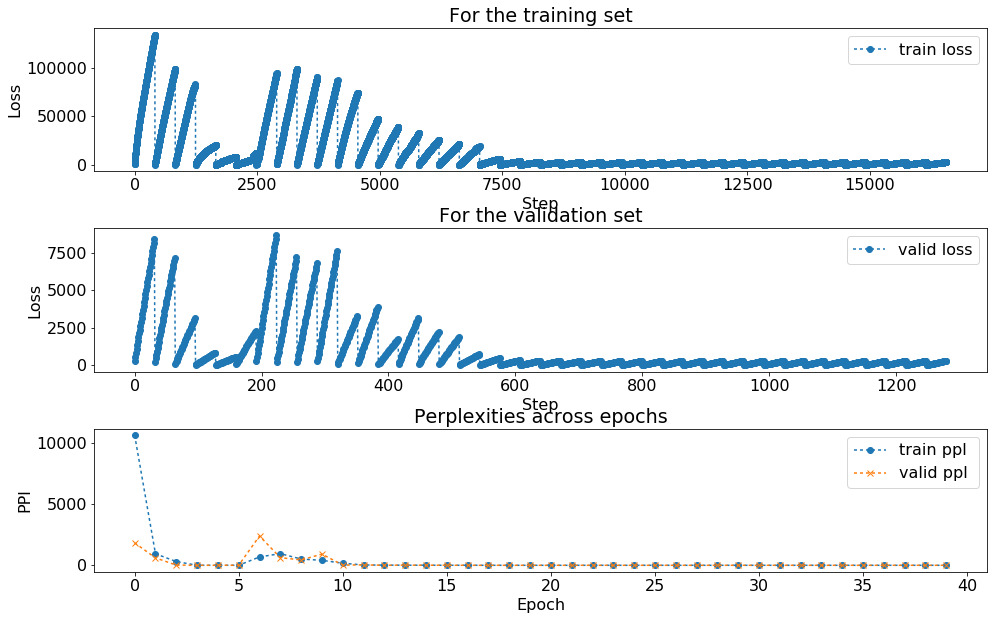

tab 9060


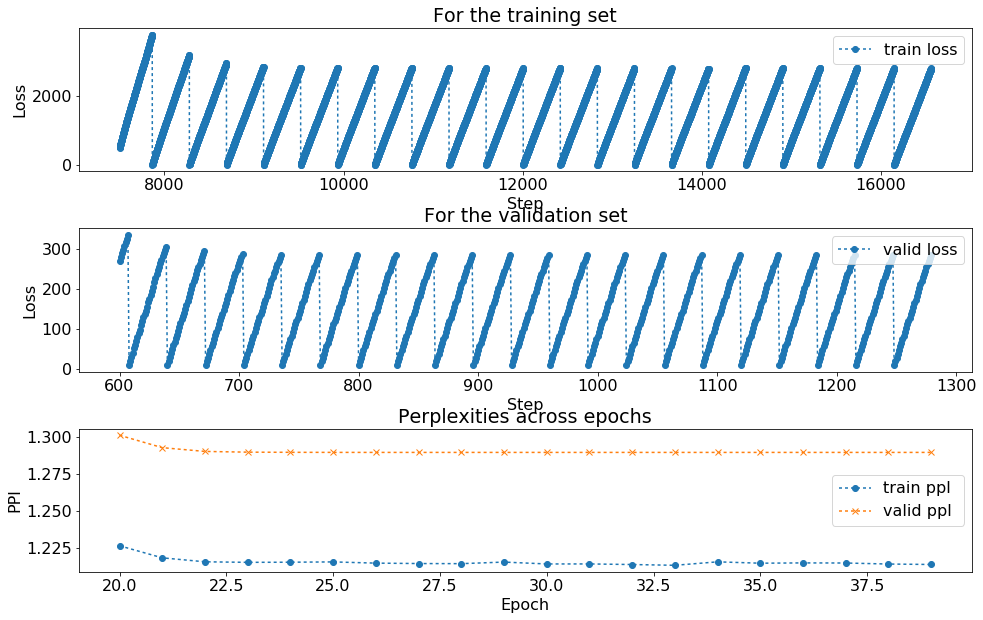

In [160]:
lc_path = "./TRANSFORMER_SGD_LR_SCHEDULE_model=TRANSFORMER_optimizer=SGD_LR_SCHEDULE_initial_lr=20_batch_size=64_seq_len=35_hidden_size=512_num_layers=6_dp_keep_prob=0.9_save_best_3"
lc_path += "/learning_curves.npy"
x = np.load(lc_path)[()]

print("x contains the following: \n")
for k,v in x.items():
    print(k , "shape : " , len(v) )
    
train_loss = x['train_losses']
valid_loss = x['val_losses']
train_ppls = x['train_ppls']
valid_ppls = x['val_ppls']

losses = [train_loss , valid_loss]
ppls   = [train_ppls , valid_ppls]

plot_loss_and_ppl( losses , ppls )
plot_loss_and_ppl( losses , ppls , [7500,600,20])